# Experiment: Step Size
In this experiment, we invesigate the effects of using a different step sizes and how it effects the sparse GP model.

## Procedure
Combine Squared-Exponential (SE) kernel, Linear kernel, Matern kernel, Sinusoidal kernel, and Spectral Mixture kernel (10 mixture components).

In [ ]:
import numpy as onp
import matplotlib.pyplot as plt
from sparse_gp import *
from plots import *
from data import *

prng_key = random.key(0)

['time_step', 'Manchester_City_F.C.', 'Chelsea_F.C.', 'Liverpool_F.C.', 'Arsenal_F.C.']


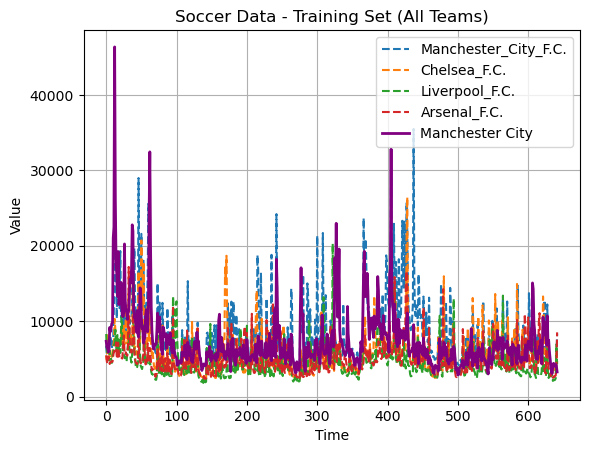

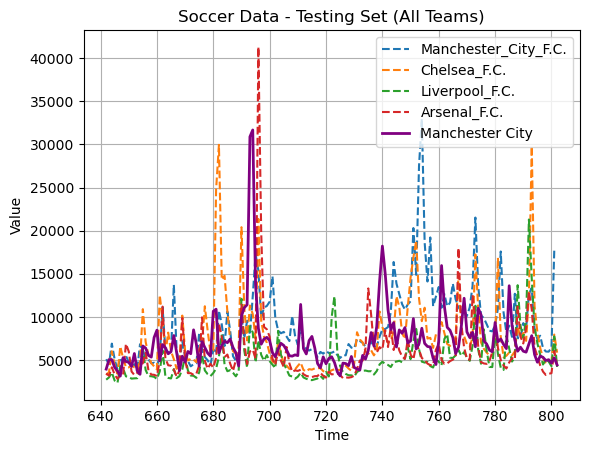

In [2]:
# Load datasets
all_data = load_all()
tech = load_tech()
politics = load_politics()
soccer = load_soccer()

# Example: Split Soccer data into training and testing sets
X_train_soccer, X_test_soccer, y_train_soccer, y_test_soccer = split_train_test_matrix(soccer, train_ratio=0.8, target_column=0)

# Generate integer day labels
time_train = np.arange(X_train_soccer.shape[0])  # Days for training set
time_test = np.arange(X_train_soccer.shape[0], X_train_soccer.shape[0] + X_test_soccer.shape[0])  # Days for testing set

# Soccer group feature names (e.g., team names)
soccer_feature_names = ["time_step"] + [
    row[0].split("_en.wikipedia.org")[0] for row in soccer if row[0] != soccer[0, 0]
]

print(soccer_feature_names)

# Plot all soccer teams in the training set
plot_time_series(
    X=X_train_soccer, 
    Y=y_train_soccer, 
    time=time_train, 
    feature_names=soccer_feature_names, 
    target_name="Manchester City",  # Example target
    title="Soccer Data - Training Set (All Teams)"
)

# Plot all soccer teams in the testing set
plot_time_series(
    X=X_test_soccer, 
    Y=y_test_soccer, 
    time=time_test, 
    feature_names=soccer_feature_names, 
    target_name="Manchester City",  # Example target
    title="Soccer Data - Testing Set (All Teams)"
)


# Step Size as 1e-7
Test on soccer data with 100 inducing points.

## Parameter Initialization

In [3]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train_soccer, num_inducing=100)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams(X_train):
    # Determine the number of input dimensions from X_train
    dims = X_train.shape[1]
    
    # Three initial weights in log space for unconstrained optimization (converted to float)
    initial_weights = [0, 0, 0, 0, 0]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0]       # [noise_variance, signal_variance, length_scale]
    hyperparams_sinusoidal = [0.1, 1.0, 10.0, 1.0]  # [noise_variance, signal_variance, period, length_scale]

    # Initialize spectral mixture hyperparameters
    num_mixtures = 10
    hyperparams_spectralmixture = [0.1]  # Start with noise_variance and number of mixtures

    for _ in range(num_mixtures):
        weight = 1 / num_mixtures  # Equal weight for each mixture initially
        mean = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        variance = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        hyperparams_spectralmixture.append(weight)  # Add weight
        hyperparams_spectralmixture.extend(mean)  # Add flattened mean
        hyperparams_spectralmixture.extend(variance)  # Add flattened variance
    #

    # Concatenate all hyperparameters
    initial_params = (
        initial_weights +
        hyperparams_sqexp +
        hyperparams_linear +
        hyperparams_matern +
        hyperparams_sinusoidal +
        hyperparams_spectralmixture
    )
    
    return np.array(initial_params, dtype=np.float32)
#


# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train_soccer)

## Define the Optimization Loop for ELBO

In [4]:
# Set the gradient ascent step size and number of steps
step_size = 1e-7
num_steps = 300

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams7, final_elbo7, history7 = empirical_bayes(X_train_soccer, y_train_soccer, Z, unconstrained_hyperparams_init, step_size, num_steps)

optimized_hyperparams = optimized_hyperparams7
final_elbo = final_elbo7
history = history7

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -575815048.8141729
Step 10, ELBO: -11667.960389933005
Step 20, ELBO: -11652.401136048116
Step 30, ELBO: -11636.877576987958
Step 40, ELBO: -11621.457808373225
Step 50, ELBO: -11606.064672505387
Step 60, ELBO: -11590.700111661865
Step 70, ELBO: -11575.44506578741
Step 80, ELBO: -11560.2179985231
Step 90, ELBO: -11545.017623536953
Step 100, ELBO: -11529.927225040949
Step 110, ELBO: -11514.863572350954
Step 120, ELBO: -11499.826663789247
Step 130, ELBO: -11484.889472534314
Step 140, ELBO: -11469.987914258241
Step 150, ELBO: -11455.111894065973
Step 160, ELBO: -11440.319316805497
Step 170, ELBO: -11425.577323826004
Step 180, ELBO: -11410.86092598509
Step 190, ELBO: -11396.21078981345
Step 200, ELBO: -11381.627108514329
Step 210, ELBO: -11367.06907183521
Step 220, ELBO: -11352.561068741097
Step 230, ELBO: -11338.134444381689
Step 240, ELBO: -11323.732295431895
Step 250, ELBO: -11309.363679069973
Step 260, ELBO: -11295.092266663427
Step 270, ELBO: -11280.845380503693
Step 280, 

In [5]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 441820.16


## Predict and Plot the Results

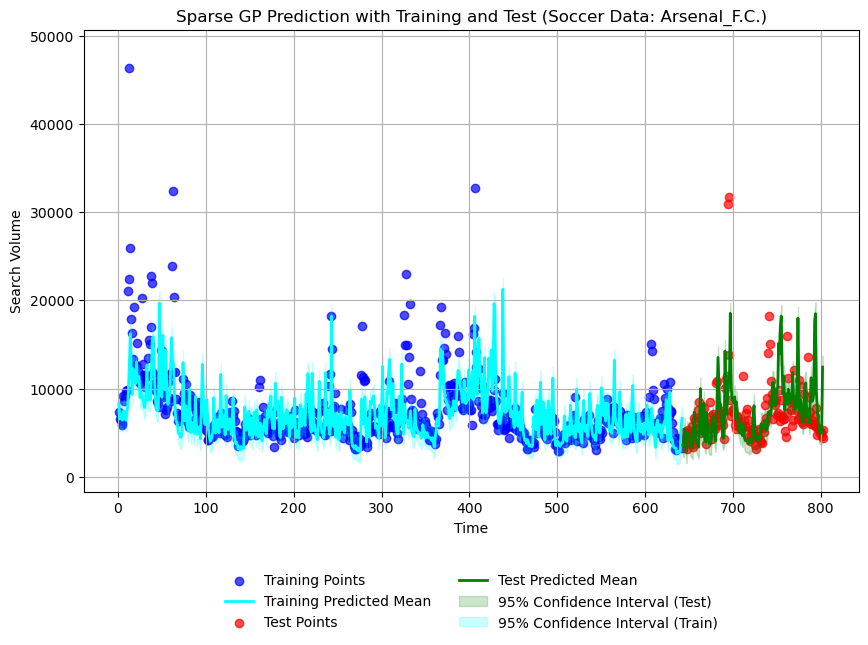

In [6]:
plot_sparse_gp_with_uncertainty_clean(
    X_train_soccer, 
    y_train_soccer, 
    X_test_soccer, 
    y_test_soccer, 
    Z, 
    optimized_hyperparams, 
    sparse_gp_posterior_predictive, 
    title_suffix=f" (Soccer Data: {soccer_feature_names[-1]})"
)

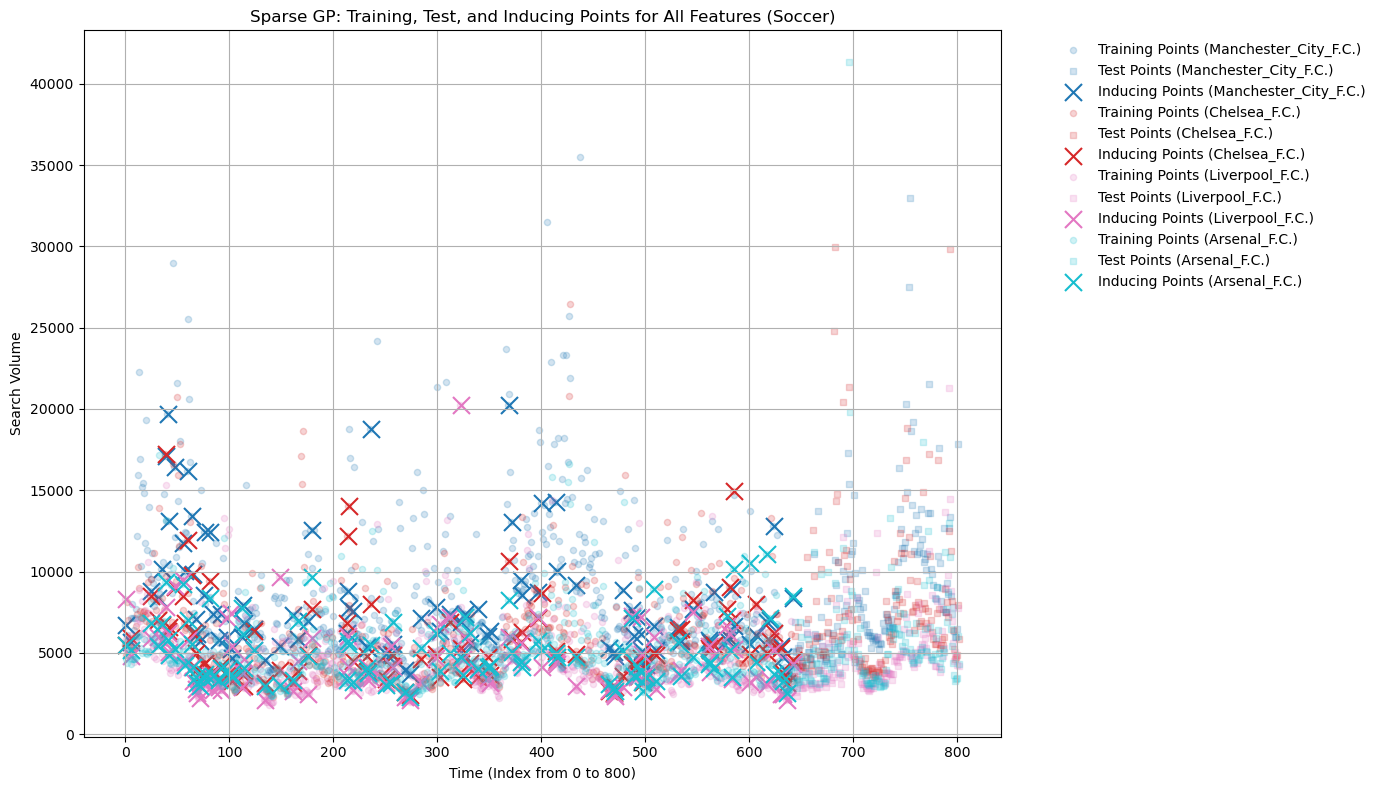

In [7]:
plot_sparse_gp_with_uncertainty_inducing(
    X_train_soccer, y_train_soccer, X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, title_suffix=" (Soccer)", feature_names=soccer_feature_names
)

In [8]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train_soccer.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

Kernel Weights:
Kernel 1 (Squared-Exponential): 1.2250
Kernel 2 (Linear): 1.0000
Kernel 3 (Matérn): 1.3679
Kernel 4 (Sinusoidal): 1.0583
Kernel 5 (Spectral Mixture): 2.2703

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 17.70%
Kernel 2 (Linear): 14.45%
Kernel 3 (Matérn): 19.76%
Kernel 4 (Sinusoidal): 15.29%
Kernel 5 (Spectral Mixture): 32.80%

Other Hyperparameters:
Kernel 1 - Noise Variance: 88364.0312
Kernel 1 - Signal Variance: 3.3299
Kernel 1 - Length Scale: 22080.1172
Kernel 2 - Noise Variance: 88364.0312
Kernel 2 - Signal Variance: 2.7182
Kernel 3 - Noise Variance: 88364.0312
Kernel 3 - Signal Variance: 3.7185
Kernel 3 - Length Scale: 17142.1426
Kernel 4 - Noise Variance: 88364.0312
Kernel 4 - Signal Variance: 2.8767
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7189
Kernel 5 - Noise Variance: 88364.0312

Spectral Mixture Kernel - Mixture 1:
Weight: 1.1996
Means: [0.22082484 0.8361463  0.0082743  1.3717978  3.6921637 ]
Variances: [1.78990135e+01 3.2699

## NLPD

In [9]:
train_nlpd = calculate_nlpd(X_train_soccer, y_train_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)
test_nlpd = calculate_nlpd(X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 14.4226
Test NLPD: 17.6101


## MSE

In [10]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test_soccer, X_train_soccer, y_train_soccer, Z, optimized_hyperparams)
mse = calculate_mse(y_test_soccer, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 17400221.1254


## ELBO Maximization

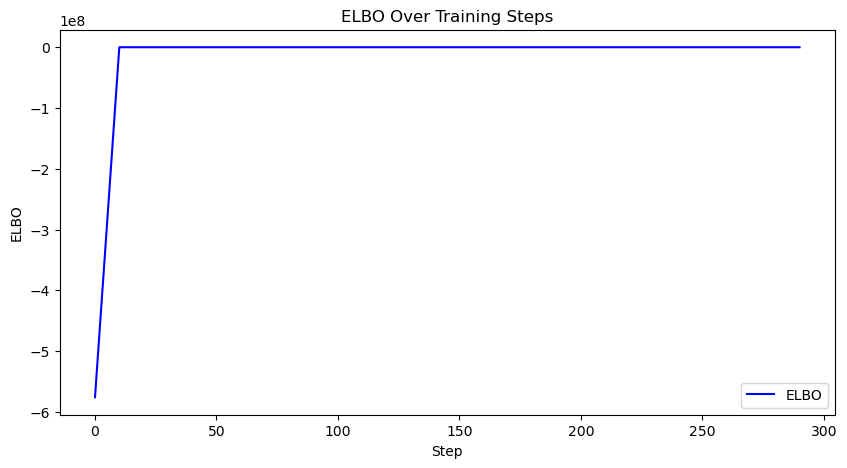

In [11]:
plot_elbo(history)

## Kernel Hyperparameters

Unchanged Hyperparameters:
 - Weight (Squared-Exponential)
 - Weight (Spectral Mixture)
 - Signal Variance (Sq-Exp)
 - Length Scale (Sq-Exp)
 - Length Scale (Matern)
 - Signal Variance (Sinusoidal)
 - Length Scale (Sinusoidal)
 - Period (Sinusoidal)
 - SM Weight 1
 - SM Mean 1, Dim 1
 - SM Variance 1, Dim 1
 - SM Mean 1, Dim 2
 - SM Variance 1, Dim 2
 - SM Mean 1, Dim 3
 - SM Variance 1, Dim 3
 - SM Mean 1, Dim 4
 - SM Variance 1, Dim 4
 - SM Mean 1, Dim 5
 - SM Variance 1, Dim 5
 - SM Weight 2
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Mean 2, Dim 2
 - SM Variance 2, Dim 2
 - SM Mean 2, Dim 3
 - SM Variance 2, Dim 3
 - SM Mean 2, Dim 4
 - SM Variance 2, Dim 4
 - SM Mean 2, Dim 5
 - SM Variance 2, Dim 5
 - SM Weight 3
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Mean 3, Dim 2
 - SM Variance 3, Dim 2
 - SM Mean 3, Dim 3
 - SM Variance 3, Dim 3
 - SM Mean 3, Dim 4
 - SM Variance 3, Dim 4
 - SM Mean 3, Dim 5
 - SM Variance 3, Dim 5
 - SM Weight 4
 - SM Mean 4, Dim 1
 - SM Vari

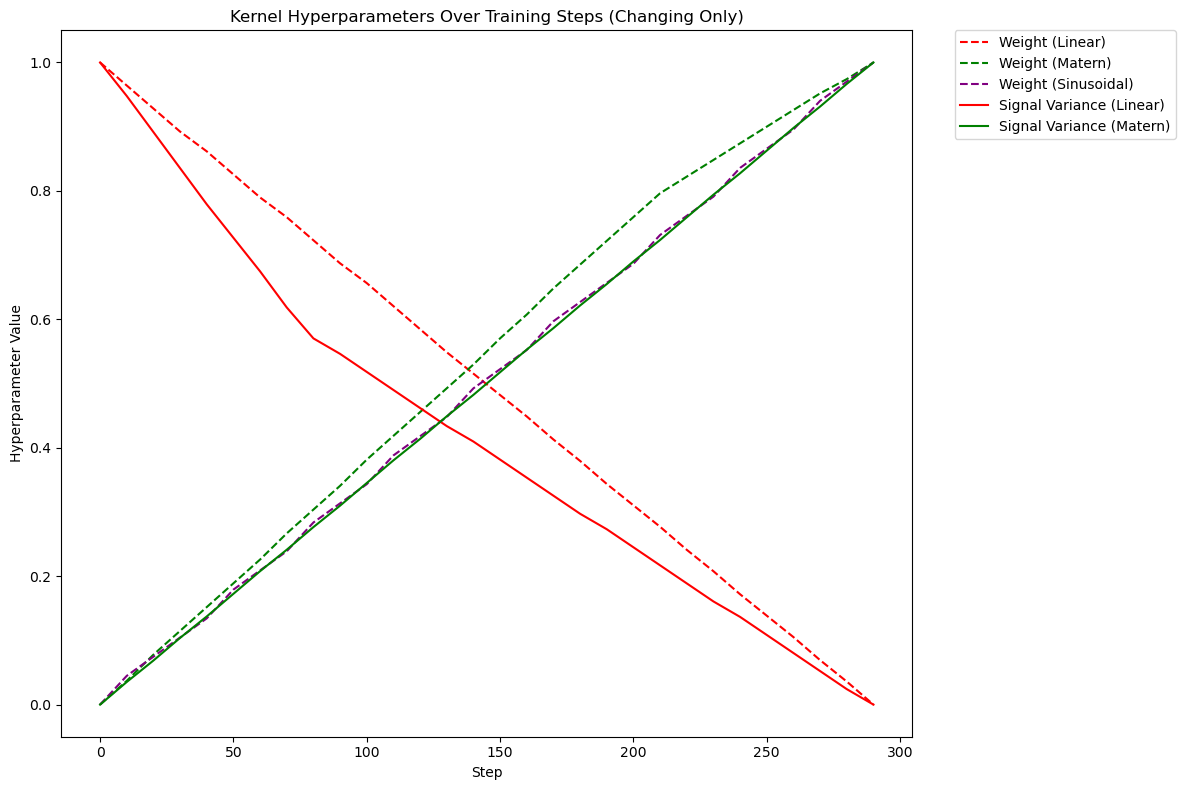

In [12]:
plot_kernel_hyperparameters(history, num_spectral_mixtures=10, dims=5)

# Step Size as 1e-8
Test on soccer data with 100 inducing points.

## Parameter Initialization

In [13]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train_soccer, num_inducing=100)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams(X_train):
    # Determine the number of input dimensions from X_train
    dims = X_train.shape[1]
    
    # Three initial weights in log space for unconstrained optimization (converted to float)
    initial_weights = [0, 0, 0, 0, 0]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0]       # [noise_variance, signal_variance, length_scale]
    hyperparams_sinusoidal = [0.1, 1.0, 10.0, 1.0]  # [noise_variance, signal_variance, period, length_scale]

    # Initialize spectral mixture hyperparameters
    num_mixtures = 10
    hyperparams_spectralmixture = [0.1]  # Start with noise_variance and number of mixtures

    for _ in range(num_mixtures):
        weight = 1 / num_mixtures  # Equal weight for each mixture initially
        mean = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        variance = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        hyperparams_spectralmixture.append(weight)  # Add weight
        hyperparams_spectralmixture.extend(mean)  # Add flattened mean
        hyperparams_spectralmixture.extend(variance)  # Add flattened variance
    #

    # Concatenate all hyperparameters
    initial_params = (
        initial_weights +
        hyperparams_sqexp +
        hyperparams_linear +
        hyperparams_matern +
        hyperparams_sinusoidal +
        hyperparams_spectralmixture
    )
    
    return np.array(initial_params, dtype=np.float32)
#


# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train_soccer)

## Define the Optimization Loop for ELBO

In [14]:
# Set the gradient ascent step size and number of steps
step_size = 1e-8
num_steps = 300

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams8, final_elbo8, history8 = empirical_bayes(X_train_soccer, y_train_soccer, Z, unconstrained_hyperparams_init, step_size, num_steps)

optimized_hyperparams = optimized_hyperparams8
final_elbo = final_elbo8
history = history8

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -575815048.8141729
Step 10, ELBO: -42284961.183380045
Step 20, ELBO: -23202740.41981932
Step 30, ELBO: -16038624.934793383
Step 40, ELBO: -12266561.247008532
Step 50, ELBO: -9934500.391890643
Step 60, ELBO: -8348635.088168015
Step 70, ELBO: -7199650.703745517
Step 80, ELBO: -6328609.29424563
Step 90, ELBO: -5645415.659292329
Step 100, ELBO: -5095150.764433135
Step 110, ELBO: -4642421.858204988
Step 120, ELBO: -4263390.426173069
Step 130, ELBO: -3941407.493031676
Step 140, ELBO: -3664487.148278617
Step 150, ELBO: -3423790.8035017387
Step 160, ELBO: -3212642.2085121837
Step 170, ELBO: -3025920.6793727786
Step 180, ELBO: -2859617.213667824
Step 190, ELBO: -2710561.9157648673
Step 200, ELBO: -2576201.139043597
Step 210, ELBO: -2454465.5169173134
Step 220, ELBO: -2343660.107521724
Step 230, ELBO: -2242377.5073812776
Step 240, ELBO: -2149441.190797515
Step 250, ELBO: -2063859.760022672
Step 260, ELBO: -1984796.904368573
Step 270, ELBO: -1911535.598320798
Step 280, ELBO: -184345

In [15]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 2149.9402


## Predict and Plot the Results

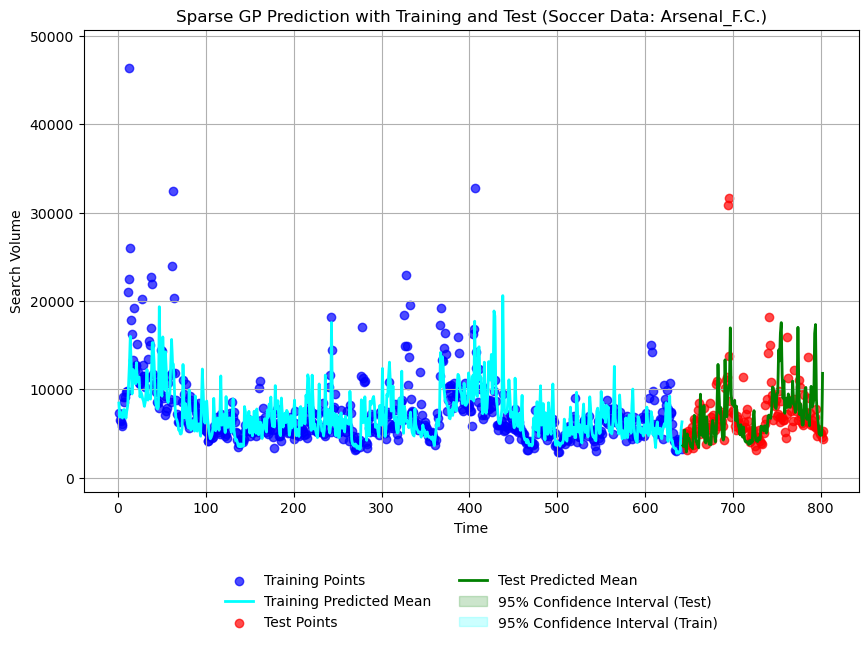

In [16]:
plot_sparse_gp_with_uncertainty_clean(
    X_train_soccer, 
    y_train_soccer, 
    X_test_soccer, 
    y_test_soccer, 
    Z, 
    optimized_hyperparams, 
    sparse_gp_posterior_predictive, 
    title_suffix=f" (Soccer Data: {soccer_feature_names[-1]})"
)

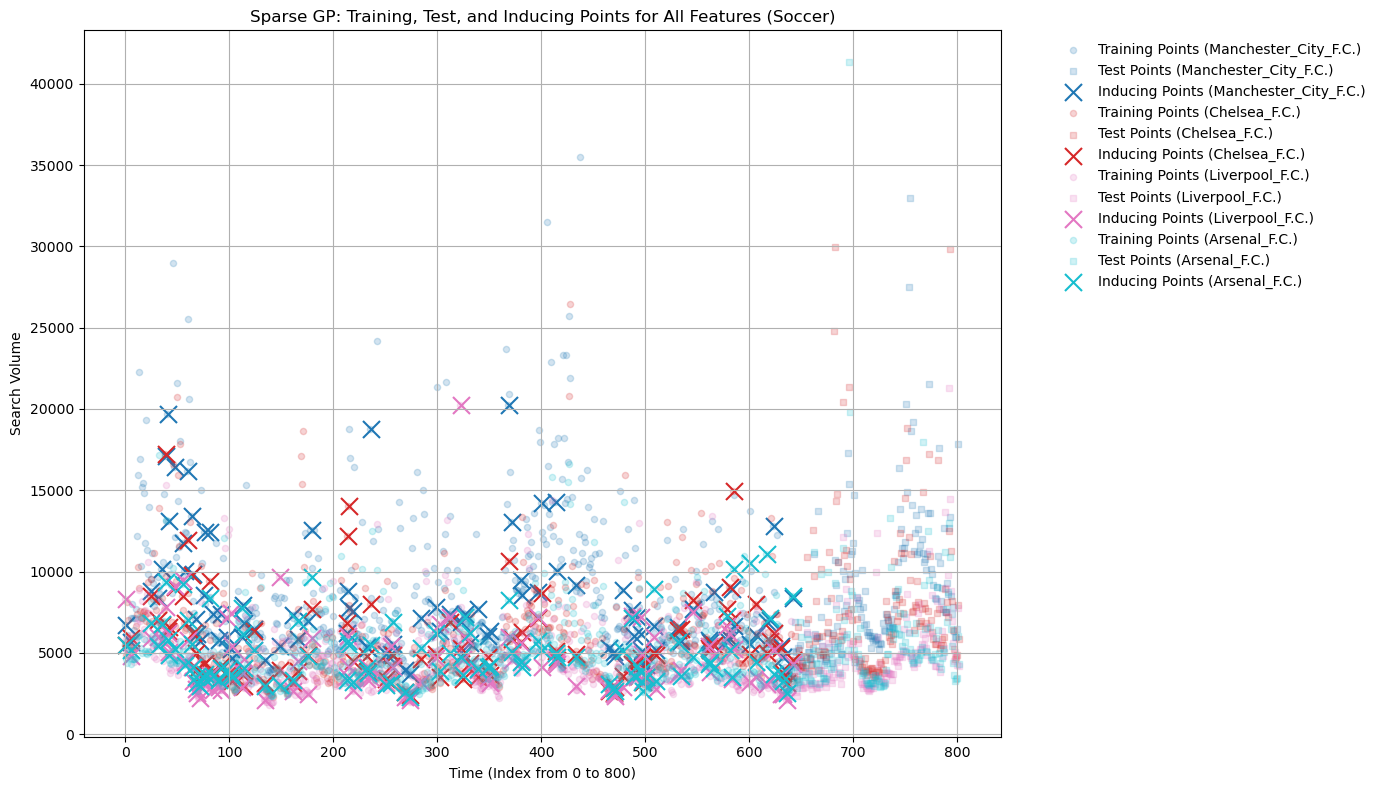

In [17]:
plot_sparse_gp_with_uncertainty_inducing(
    X_train_soccer, y_train_soccer, X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, title_suffix=" (Soccer)", feature_names=soccer_feature_names
)

In [18]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train_soccer.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

Kernel Weights:
Kernel 1 (Squared-Exponential): 1.0525
Kernel 2 (Linear): 1.0000
Kernel 3 (Matérn): 1.5270
Kernel 4 (Sinusoidal): 1.1713
Kernel 5 (Spectral Mixture): 1.2444

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 17.56%
Kernel 2 (Linear): 16.68%
Kernel 3 (Matérn): 25.47%
Kernel 4 (Sinusoidal): 19.54%
Kernel 5 (Spectral Mixture): 20.76%

Other Hyperparameters:
Kernel 1 - Noise Variance: 429.9880
Kernel 1 - Signal Variance: 2.8609
Kernel 1 - Length Scale: 22034.1973
Kernel 2 - Noise Variance: 429.9880
Kernel 2 - Signal Variance: 2.7183
Kernel 3 - Noise Variance: 429.9880
Kernel 3 - Signal Variance: 4.1509
Kernel 3 - Length Scale: 18278.3535
Kernel 4 - Noise Variance: 429.9880
Kernel 4 - Signal Variance: 3.1841
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7184
Kernel 5 - Noise Variance: 429.9880

Spectral Mixture Kernel - Mixture 1:
Weight: 1.1296
Means: [0.22082484 0.8361463  0.0082743  1.3717978  3.6921637 ]
Variances: [1.78990135e+01 3.26999130e+01 1

## NLPD

In [19]:
train_nlpd = calculate_nlpd(X_train_soccer, y_train_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)
test_nlpd = calculate_nlpd(X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 1314.7959
Test NLPD: 1888.8617


## MSE

In [20]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test_soccer, X_train_soccer, y_train_soccer, Z, optimized_hyperparams)
mse = calculate_mse(y_test_soccer, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 16296801.5991


## ELBO Maximization

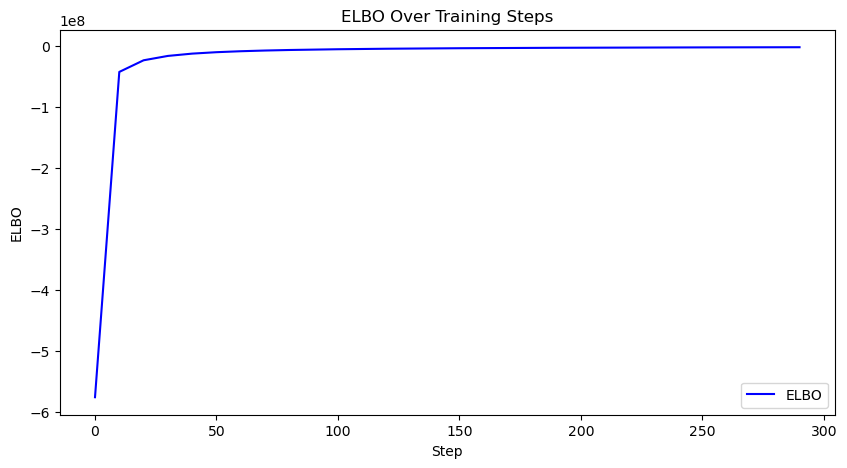

In [21]:
plot_elbo(history)

## Kernel Hyperparameters

Unchanged Hyperparameters:
 - Signal Variance (Linear)
 - Length Scale (Sinusoidal)
 - SM Mean 1, Dim 1
 - SM Variance 1, Dim 1
 - SM Mean 1, Dim 2
 - SM Variance 1, Dim 2
 - SM Mean 1, Dim 3
 - SM Variance 1, Dim 3
 - SM Mean 1, Dim 4
 - SM Variance 1, Dim 4
 - SM Mean 1, Dim 5
 - SM Variance 1, Dim 5
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Mean 2, Dim 2
 - SM Variance 2, Dim 2
 - SM Mean 2, Dim 3
 - SM Variance 2, Dim 3
 - SM Mean 2, Dim 4
 - SM Variance 2, Dim 4
 - SM Mean 2, Dim 5
 - SM Variance 2, Dim 5
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Mean 3, Dim 2
 - SM Variance 3, Dim 2
 - SM Mean 3, Dim 3
 - SM Variance 3, Dim 3
 - SM Mean 3, Dim 4
 - SM Variance 3, Dim 4
 - SM Mean 3, Dim 5
 - SM Variance 3, Dim 5
 - SM Mean 4, Dim 1
 - SM Variance 4, Dim 1
 - SM Mean 4, Dim 2
 - SM Variance 4, Dim 2
 - SM Mean 4, Dim 3
 - SM Variance 4, Dim 3
 - SM Mean 4, Dim 4
 - SM Variance 4, Dim 4
 - SM Mean 4, Dim 5
 - SM Variance 4, Dim 5
 - SM Mean 5, Dim 1
 - SM Variance 5

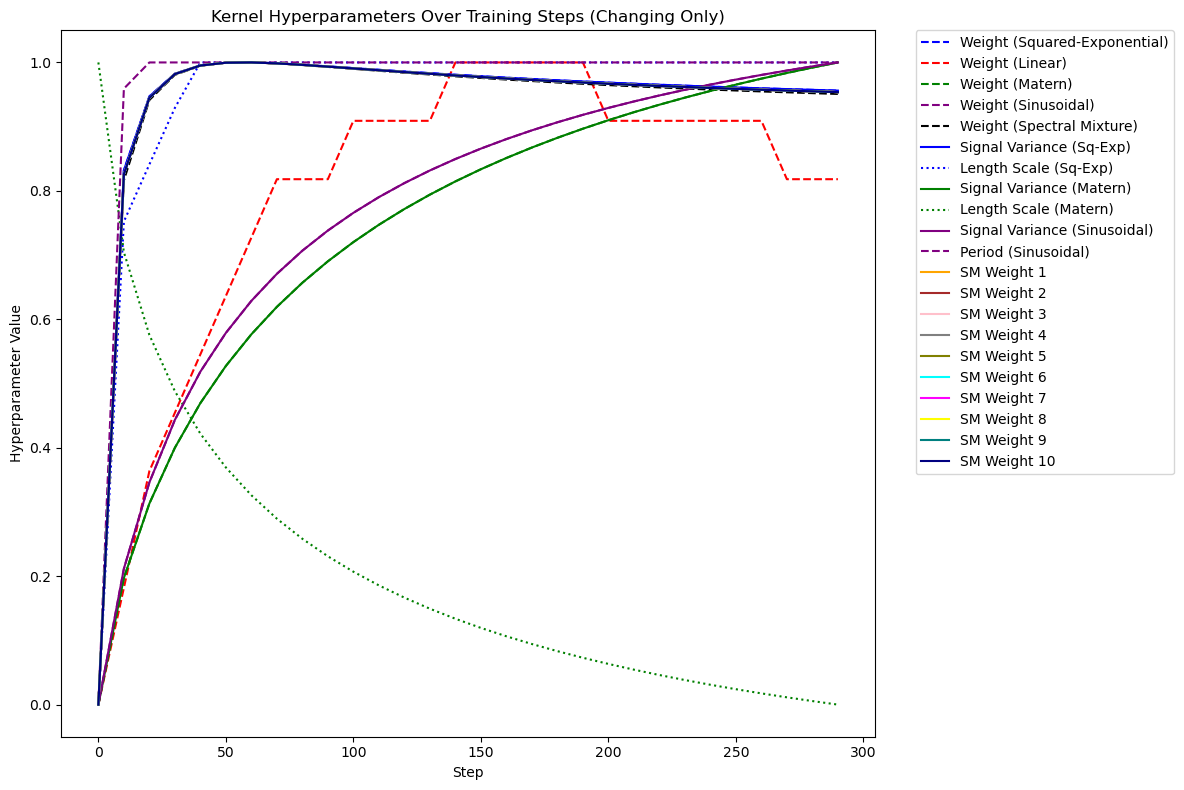

In [22]:
plot_kernel_hyperparameters(history, num_spectral_mixtures=10, dims=5)

# Step Size as 1e-9
Test on soccer data with 100 inducing points.

## Parameter Initialization

In [23]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train_soccer, num_inducing=100)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams(X_train):
    # Determine the number of input dimensions from X_train
    dims = X_train.shape[1]
    
    # Three initial weights in log space for unconstrained optimization (converted to float)
    initial_weights = [0, 0, 0, 0, 0]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0]       # [noise_variance, signal_variance, length_scale]
    hyperparams_sinusoidal = [0.1, 1.0, 10.0, 1.0]  # [noise_variance, signal_variance, period, length_scale]

    # Initialize spectral mixture hyperparameters
    num_mixtures = 10
    hyperparams_spectralmixture = [0.1]  # Start with noise_variance and number of mixtures

    for _ in range(num_mixtures):
        weight = 1 / num_mixtures  # Equal weight for each mixture initially
        mean = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        variance = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        hyperparams_spectralmixture.append(weight)  # Add weight
        hyperparams_spectralmixture.extend(mean)  # Add flattened mean
        hyperparams_spectralmixture.extend(variance)  # Add flattened variance
    #

    # Concatenate all hyperparameters
    initial_params = (
        initial_weights +
        hyperparams_sqexp +
        hyperparams_linear +
        hyperparams_matern +
        hyperparams_sinusoidal +
        hyperparams_spectralmixture
    )
    
    return np.array(initial_params, dtype=np.float32)
#


# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train_soccer)

## Define the Optimization Loop for ELBO

In [24]:
# Set the gradient ascent step size and number of steps
step_size = 1e-9
num_steps = 300

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams9, final_elbo9, history9 = empirical_bayes(X_train_soccer, y_train_soccer, Z, unconstrained_hyperparams_init, step_size, num_steps)

optimized_hyperparams = optimized_hyperparams9
final_elbo = final_elbo9
history = history9

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -575815048.8141729
Step 10, ELBO: -269936884.49353856
Step 20, ELBO: -177750029.09173957
Step 30, ELBO: -132768305.87406215
Step 40, ELBO: -106029313.3939693
Step 50, ELBO: -88280138.4308258
Step 60, ELBO: -75630740.47702666
Step 70, ELBO: -66155889.09703786
Step 80, ELBO: -58792429.1454374
Step 90, ELBO: -52904667.702454105
Step 100, ELBO: -48089148.06545629
Step 110, ELBO: -44077263.47181014
Step 120, ELBO: -40683261.41275226
Step 130, ELBO: -37774587.94816376
Step 140, ELBO: -35254054.23293297
Step 150, ELBO: -33048830.45909881
Step 160, ELBO: -31103213.491131023
Step 170, ELBO: -29373918.779726684
Step 180, ELBO: -27826749.888596524
Step 190, ELBO: -26434384.421042
Step 200, ELBO: -25174691.845829573
Step 210, ELBO: -24029565.364745166
Step 220, ELBO: -22984073.58866302
Step 230, ELBO: -22025730.85315648
Step 240, ELBO: -21144090.261042032
Step 250, ELBO: -20330283.226307962
Step 260, ELBO: -19576775.15837117
Step 270, ELBO: -18877101.131413143
Step 280, ELBO: -182256

In [25]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 206.1948


## Predict and Plot the Results

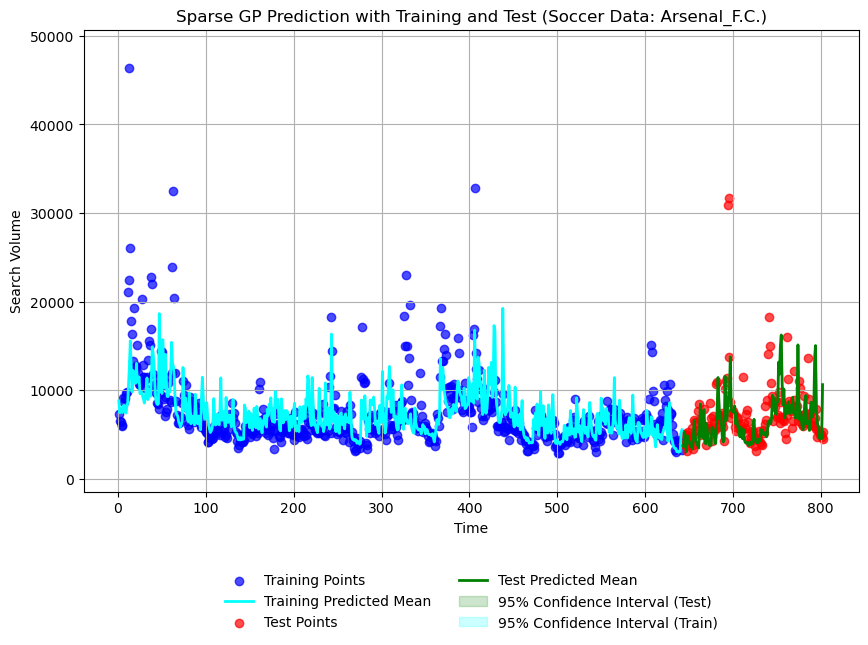

In [26]:
plot_sparse_gp_with_uncertainty_clean(
    X_train_soccer, 
    y_train_soccer, 
    X_test_soccer, 
    y_test_soccer, 
    Z, 
    optimized_hyperparams, 
    sparse_gp_posterior_predictive, 
    title_suffix=f" (Soccer Data: {soccer_feature_names[-1]})"
)

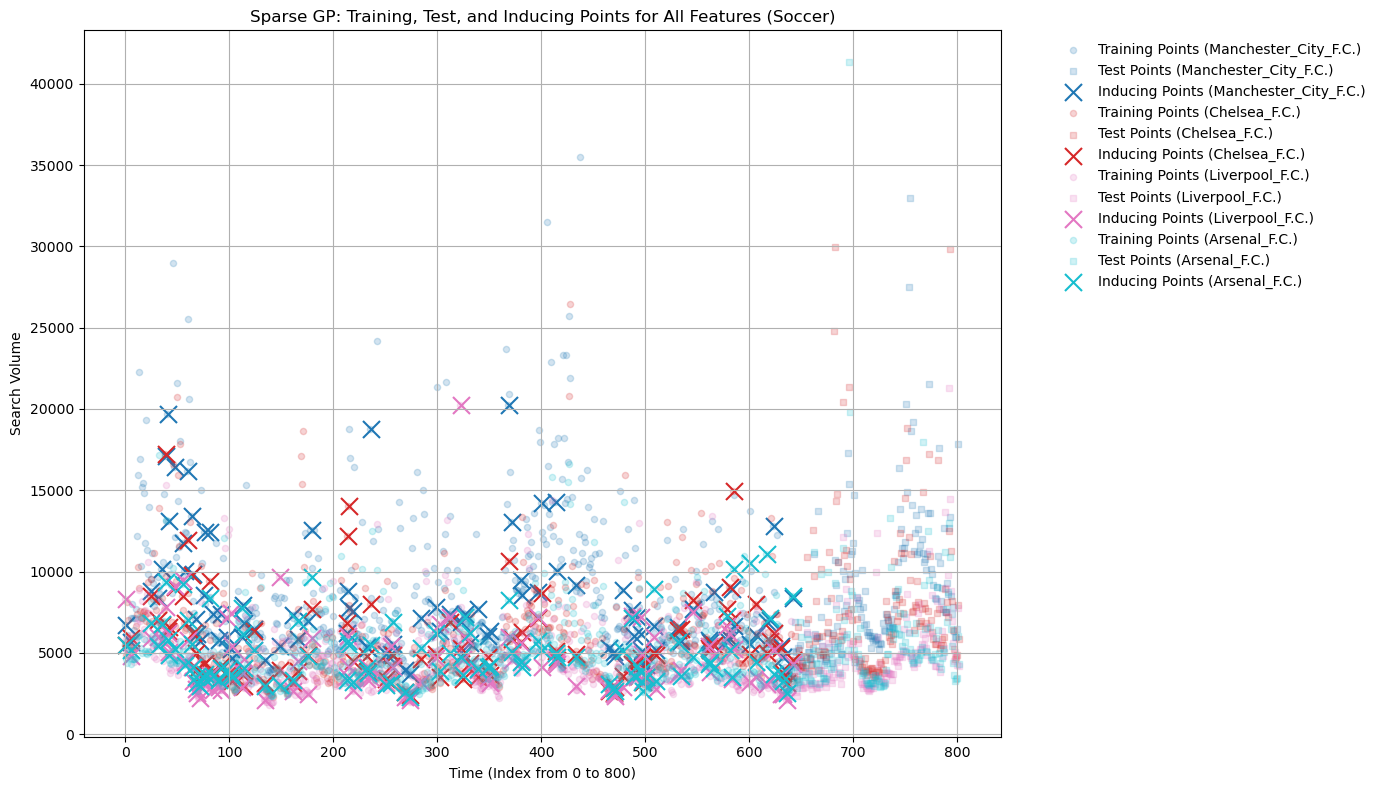

In [27]:
plot_sparse_gp_with_uncertainty_inducing(
    X_train_soccer, y_train_soccer, X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, title_suffix=" (Soccer)", feature_names=soccer_feature_names
)

In [28]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train_soccer.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

Kernel Weights:
Kernel 1 (Squared-Exponential): 1.0549
Kernel 2 (Linear): 1.0000
Kernel 3 (Matérn): 1.2277
Kernel 4 (Sinusoidal): 1.0792
Kernel 5 (Spectral Mixture): 1.2618

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 18.76%
Kernel 2 (Linear): 17.78%
Kernel 3 (Matérn): 21.83%
Kernel 4 (Sinusoidal): 19.19%
Kernel 5 (Spectral Mixture): 22.44%

Other Hyperparameters:
Kernel 1 - Noise Variance: 41.2390
Kernel 1 - Signal Variance: 2.8674
Kernel 1 - Length Scale: 22031.8242
Kernel 2 - Noise Variance: 41.2390
Kernel 2 - Signal Variance: 2.7183
Kernel 3 - Noise Variance: 41.2390
Kernel 3 - Signal Variance: 3.3372
Kernel 3 - Length Scale: 19889.0664
Kernel 4 - Noise Variance: 41.2390
Kernel 4 - Signal Variance: 2.9335
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7183
Kernel 5 - Noise Variance: 41.2390

Spectral Mixture Kernel - Mixture 1:
Weight: 1.1312
Means: [0.22082484 0.8361463  0.0082743  1.3717978  3.6921637 ]
Variances: [1.78990135e+01 3.26999130e+01 1.2465

## NLPD

In [29]:
train_nlpd = calculate_nlpd(X_train_soccer, y_train_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)
test_nlpd = calculate_nlpd(X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 12333.5733
Test NLPD: 17239.3041


## MSE

In [30]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test_soccer, X_train_soccer, y_train_soccer, Z, optimized_hyperparams)
mse = calculate_mse(y_test_soccer, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 14980071.8328


## ELBO Maximization

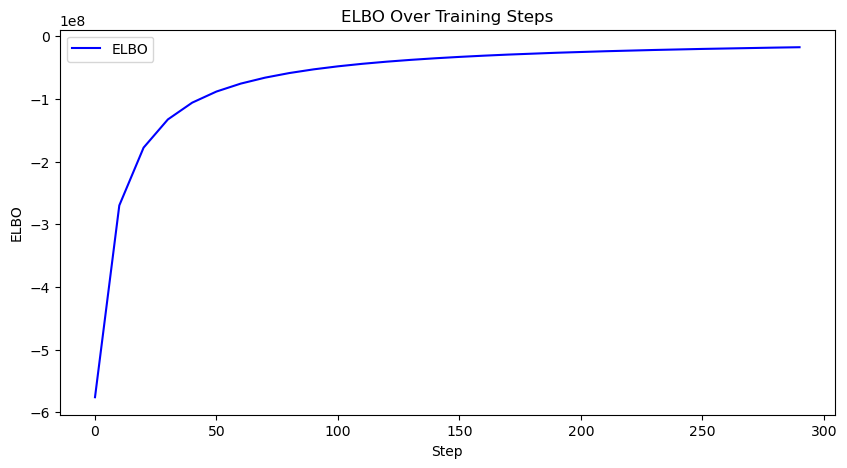

In [31]:
plot_elbo(history)

## Kernel Hyperparameters

Unchanged Hyperparameters:
 - Length Scale (Sinusoidal)
 - SM Mean 1, Dim 1
 - SM Variance 1, Dim 1
 - SM Mean 1, Dim 2
 - SM Variance 1, Dim 2
 - SM Mean 1, Dim 3
 - SM Variance 1, Dim 3
 - SM Mean 1, Dim 4
 - SM Variance 1, Dim 4
 - SM Mean 1, Dim 5
 - SM Variance 1, Dim 5
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Mean 2, Dim 2
 - SM Variance 2, Dim 2
 - SM Mean 2, Dim 3
 - SM Variance 2, Dim 3
 - SM Mean 2, Dim 4
 - SM Variance 2, Dim 4
 - SM Mean 2, Dim 5
 - SM Variance 2, Dim 5
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Mean 3, Dim 2
 - SM Variance 3, Dim 2
 - SM Mean 3, Dim 3
 - SM Variance 3, Dim 3
 - SM Mean 3, Dim 4
 - SM Variance 3, Dim 4
 - SM Mean 3, Dim 5
 - SM Variance 3, Dim 5
 - SM Mean 4, Dim 1
 - SM Variance 4, Dim 1
 - SM Mean 4, Dim 2
 - SM Variance 4, Dim 2
 - SM Mean 4, Dim 3
 - SM Variance 4, Dim 3
 - SM Mean 4, Dim 4
 - SM Variance 4, Dim 4
 - SM Mean 4, Dim 5
 - SM Variance 4, Dim 5
 - SM Mean 5, Dim 1
 - SM Variance 5, Dim 1
 - SM Mean 5, Dim 2


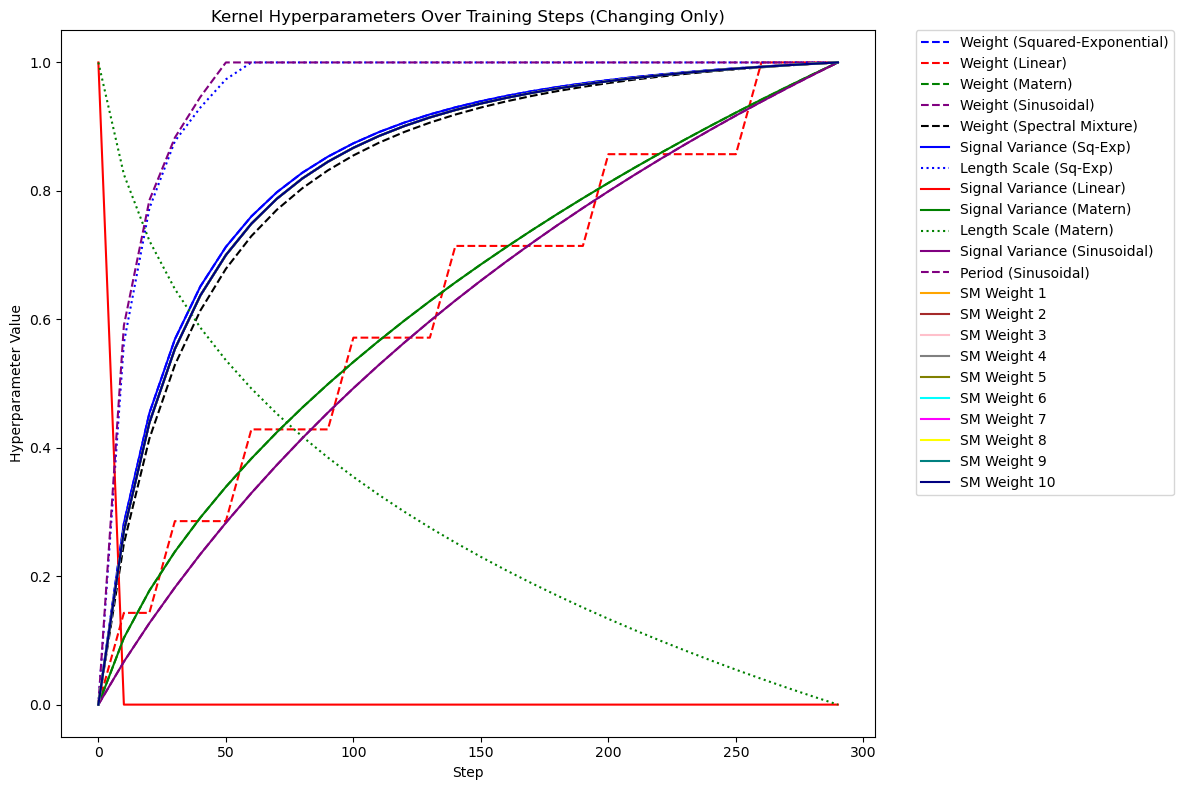

In [32]:
plot_kernel_hyperparameters(history, num_spectral_mixtures=10, dims=5)

# Step Size as 1e-10
Test on soccer data with 100 inducing points.

## Parameter Initialization

In [33]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train_soccer, num_inducing=100)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams(X_train):
    # Determine the number of input dimensions from X_train
    dims = X_train.shape[1]
    
    # Three initial weights in log space for unconstrained optimization (converted to float)
    initial_weights = [0, 0, 0, 0, 0]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0]       # [noise_variance, signal_variance, length_scale]
    hyperparams_sinusoidal = [0.1, 1.0, 10.0, 1.0]  # [noise_variance, signal_variance, period, length_scale]

    # Initialize spectral mixture hyperparameters
    num_mixtures = 10
    hyperparams_spectralmixture = [0.1]  # Start with noise_variance and number of mixtures

    for _ in range(num_mixtures):
        weight = 1 / num_mixtures  # Equal weight for each mixture initially
        mean = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        variance = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        hyperparams_spectralmixture.append(weight)  # Add weight
        hyperparams_spectralmixture.extend(mean)  # Add flattened mean
        hyperparams_spectralmixture.extend(variance)  # Add flattened variance
    #

    # Concatenate all hyperparameters
    initial_params = (
        initial_weights +
        hyperparams_sqexp +
        hyperparams_linear +
        hyperparams_matern +
        hyperparams_sinusoidal +
        hyperparams_spectralmixture
    )
    
    return np.array(initial_params, dtype=np.float32)
#


# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train_soccer)

## Define the Optimization Loop for ELBO

In [34]:
# Set the gradient ascent step size and number of steps
step_size = 1e-10
num_steps = 300

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams10, final_elbo10, history10 = empirical_bayes(X_train_soccer, y_train_soccer, Z, unconstrained_hyperparams_init, step_size, num_steps)

optimized_hyperparams = optimized_hyperparams10
final_elbo = final_elbo10
history = history10

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -575815048.8141729
Step 10, ELBO: -518605928.30633307
Step 20, ELBO: -471840559.68575674
Step 30, ELBO: -432886231.95179635
Step 40, ELBO: -399927959.6890921
Step 50, ELBO: -371674044.5623635
Step 60, ELBO: -347179700.22453445
Step 70, ELBO: -325738015.0653
Step 80, ELBO: -306809142.97769165
Step 90, ELBO: -289973905.46264386
Step 100, ELBO: -274901639.6830534
Step 110, ELBO: -261327905.36958018
Step 120, ELBO: -249038810.38580206
Step 130, ELBO: -237859516.04005742
Step 140, ELBO: -227645548.40262973
Step 150, ELBO: -218276589.20451325
Step 160, ELBO: -209651463.90687564
Step 170, ELBO: -201684627.14438522
Step 180, ELBO: -194303321.08986053
Step 190, ELBO: -187444922.65122348
Step 200, ELBO: -181055612.35880148
Step 210, ELBO: -175088717.97909182
Step 220, ELBO: -169503546.80872053
Step 230, ELBO: -164264474.85330814
Step 240, ELBO: -159340171.59160897
Step 250, ELBO: -154703100.86909002
Step 260, ELBO: -150328709.11586377
Step 270, ELBO: -146195224.30427885
Step 280, E

In [35]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 24.534286


## Predict and Plot the Results

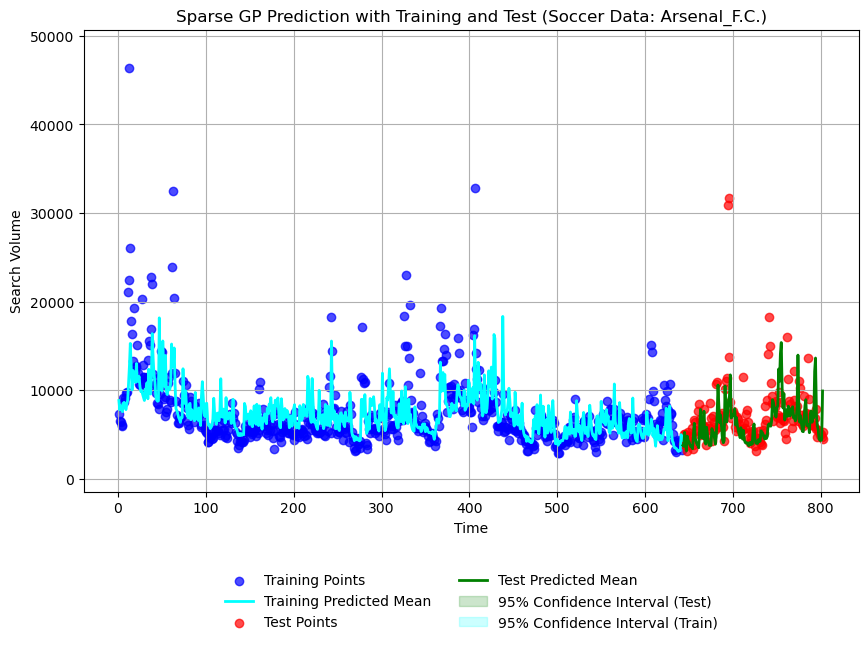

In [36]:
plot_sparse_gp_with_uncertainty_clean(
    X_train_soccer, 
    y_train_soccer, 
    X_test_soccer, 
    y_test_soccer, 
    Z, 
    optimized_hyperparams, 
    sparse_gp_posterior_predictive, 
    title_suffix=f" (Soccer Data: {soccer_feature_names[-1]})"
)

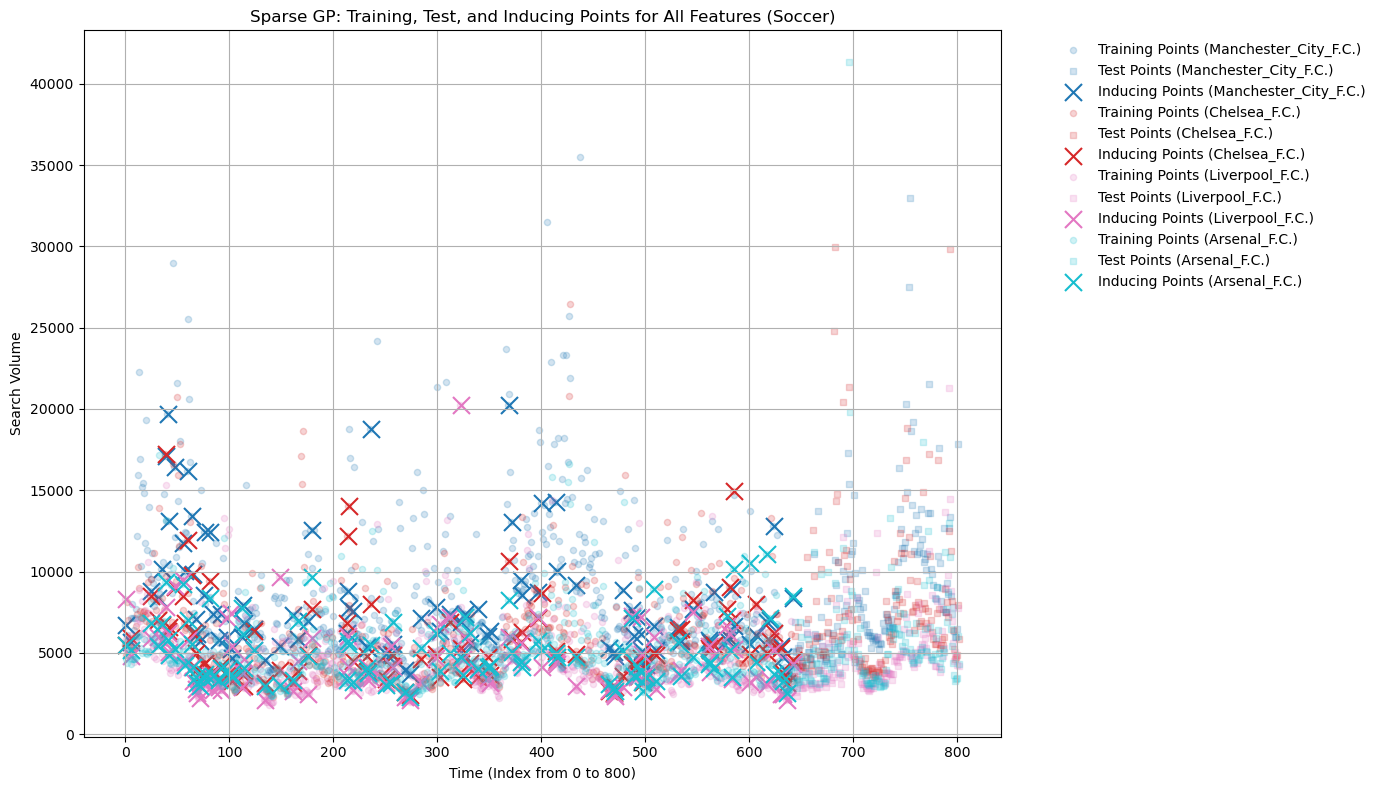

In [37]:
plot_sparse_gp_with_uncertainty_inducing(
    X_train_soccer, y_train_soccer, X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, title_suffix=" (Soccer)", feature_names=soccer_feature_names
)

In [38]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train_soccer.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

Kernel Weights:
Kernel 1 (Squared-Exponential): 1.0313
Kernel 2 (Linear): 1.0000
Kernel 3 (Matérn): 1.0541
Kernel 4 (Sinusoidal): 1.0142
Kernel 5 (Spectral Mixture): 1.1386

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 19.69%
Kernel 2 (Linear): 19.09%
Kernel 3 (Matérn): 20.12%
Kernel 4 (Sinusoidal): 19.36%
Kernel 5 (Spectral Mixture): 21.74%

Other Hyperparameters:
Kernel 1 - Noise Variance: 4.9069
Kernel 1 - Signal Variance: 2.8033
Kernel 1 - Length Scale: 22030.4570
Kernel 2 - Noise Variance: 4.9069
Kernel 2 - Signal Variance: 2.7183
Kernel 3 - Noise Variance: 4.9069
Kernel 3 - Signal Variance: 2.8653
Kernel 3 - Length Scale: 21266.6875
Kernel 4 - Noise Variance: 4.9069
Kernel 4 - Signal Variance: 2.7569
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7183
Kernel 5 - Noise Variance: 4.9069

Spectral Mixture Kernel - Mixture 1:
Weight: 1.1196
Means: [0.22082484 0.8361463  0.0082743  1.3717978  3.6921637 ]
Variances: [1.78990135e+01 3.26999130e+01 1.24653816e

## NLPD

In [39]:
train_nlpd = calculate_nlpd(X_train_soccer, y_train_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)
test_nlpd = calculate_nlpd(X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 75752.3455
Test NLPD: 108631.9068


## MSE

In [40]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test_soccer, X_train_soccer, y_train_soccer, Z, optimized_hyperparams)
mse = calculate_mse(y_test_soccer, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 14709289.1140


## ELBO Maximization

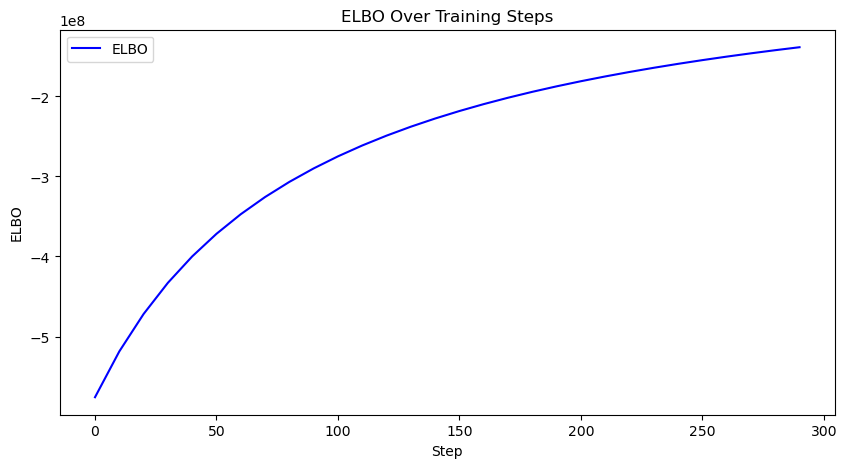

In [72]:
plot_elbo(history)

## Kernel Hyperparameters

Unchanged Hyperparameters:
 - Signal Variance (Linear)
 - Length Scale (Sinusoidal)
 - SM Mean 1, Dim 1
 - SM Variance 1, Dim 1
 - SM Mean 1, Dim 2
 - SM Variance 1, Dim 2
 - SM Mean 1, Dim 3
 - SM Variance 1, Dim 3
 - SM Mean 1, Dim 4
 - SM Variance 1, Dim 4
 - SM Mean 1, Dim 5
 - SM Variance 1, Dim 5
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Mean 2, Dim 2
 - SM Variance 2, Dim 2
 - SM Mean 2, Dim 3
 - SM Variance 2, Dim 3
 - SM Mean 2, Dim 4
 - SM Variance 2, Dim 4
 - SM Mean 2, Dim 5
 - SM Variance 2, Dim 5
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Mean 3, Dim 2
 - SM Variance 3, Dim 2
 - SM Mean 3, Dim 3
 - SM Variance 3, Dim 3
 - SM Mean 3, Dim 4
 - SM Variance 3, Dim 4
 - SM Mean 3, Dim 5
 - SM Variance 3, Dim 5
 - SM Mean 4, Dim 1
 - SM Variance 4, Dim 1
 - SM Mean 4, Dim 2
 - SM Variance 4, Dim 2
 - SM Mean 4, Dim 3
 - SM Variance 4, Dim 3
 - SM Mean 4, Dim 4
 - SM Variance 4, Dim 4
 - SM Mean 4, Dim 5
 - SM Variance 4, Dim 5
 - SM Mean 5, Dim 1
 - SM Variance 5

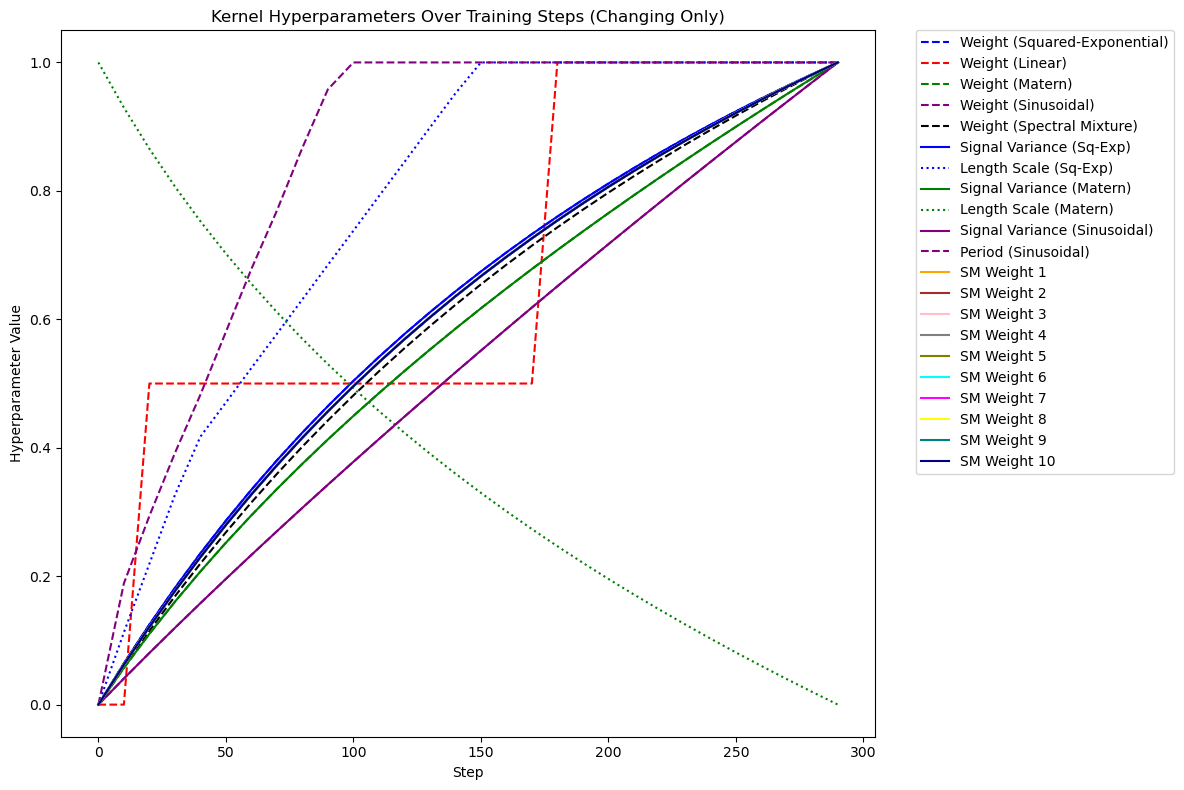

In [42]:
plot_kernel_hyperparameters(history, num_spectral_mixtures=10, dims=5)

# Comparative Plots

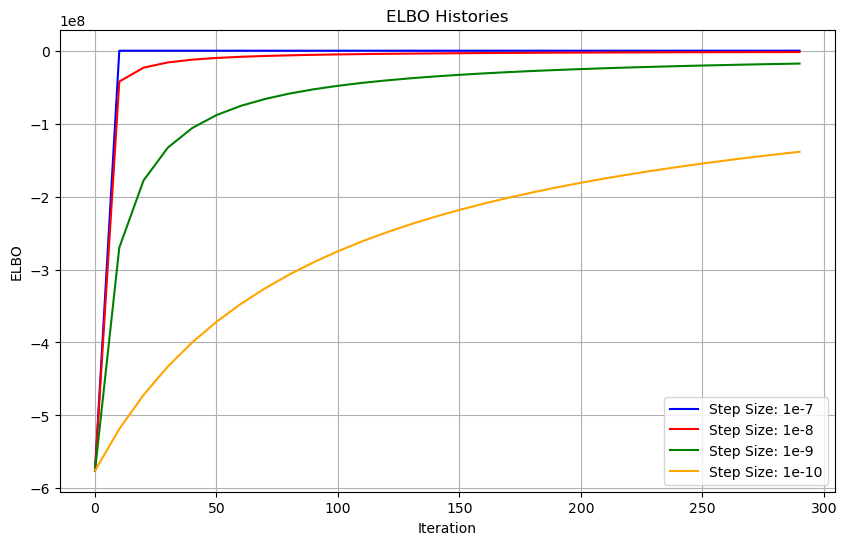

In [ ]:
# Get a list of all ELBO histories
def getElboHistories(history):
    yVal = [history[i]['elbo'] for i in range(0, len(history), 10)]
    xVal = [i for i in range(0, len(history), 10)]
    return xVal, yVal

# Plot all ELBO histories
plt.figure(figsize=(10, 6))
plt.title("ELBO Histories")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.grid(True)
plt.plot(*getElboHistories(history7), label="Step Size: 1e-7", color='blue')
plt.plot(*getElboHistories(history8), label="Step Size: 1e-8", color='red')
plt.plot(*getElboHistories(history9), label="Step Size: 1e-9", color='green')
plt.plot(*getElboHistories(history10), label="Step Size: 1e-10", color='orange')
plt.legend()
plt.show()


In [81]:
# Determine which individual hyperparameters change over the course of optimization
def countIndividualChanges(history):
    changes_per_index = [0] * len(history[0]['hyperparams']) 
    for i in range(1, len(history)):
        for j in range(len(history[i]['hyperparams'])):
            if history[i]['hyperparams'][j] != history[i - 1]['hyperparams'][j]:
                changes_per_index[j] += 1  
    return changes_per_index

def howManyChanges(history):
    individual_changes = countIndividualChanges(history)
    does_change = [1 if i > 0 else 0 for i in individual_changes]
    return sum(does_change)

# Total Changes
print("Total Changes:")
print("Step Size: 1e-7", howManyChanges(history7))
print("Step Size: 1e-8", howManyChanges(history8))
print("Step Size: 1e-9", howManyChanges(history9))
print("Step Size: 1e-10", howManyChanges(history10))

Total Changes:
Step Size: 1e-7 10
Step Size: 1e-8 26
Step Size: 1e-9 27
Step Size: 1e-10 26
